### Time Series Analysis
#### Time series analysis can be useful to see how a given asset, security, or economic variable changes over time. It can also be used to examine how the changes associated with the chosen data point compare to shifts in other variables over the same time period.
#### In this notebook I will discribe: 
#### 1- Time sereise components and HP filter
#### 2- ETS Model
#### 3- EWMA Models & SMA Models
#### 4- Holt winter method


#### Importing and read time sereise by pandas:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('../input/cryptocurrency-financial-data/consolidated_coin_data.csv',index_col='Date')
df.index=pd.to_datetime(df.index)
df.dropna()


#### To make the data simple as possiple for analysis the close with time, I will drop all cols except Close and reduce data to 1000 col.

In [ ]:
df= df.drop(['Currency', 'Open', 'High', 'Low', 'Volume', 'Market Cap'],axis=1)
df= df.iloc[1:1000]
df['Close']= pd.to_numeric(df['Close'])


## Intoduction into time seriese properties:
### We will use the following three components describes the time series.

### 1- Trend : we describe it as upward or downward
![Trend](https://productimize.com/wp-content/uploads/2019/08/Component-in-Time-Series_Trend.png)
### 2- Seasonality: Reapeating trend 
![Seasonality](https://miro.medium.com/max/2100/1*po-ZfwDPLCS5cIQBG_S-lA.png)

### 3- Cyclical: Trends with no set repetition
![Cyclical](https://images.slideplayer.com/32/9883613/slides/slide_5.jpg)


### 1- Hodrick prescott filter (hp filter):
#### it seperates time series into trend component and cyclical component, these component determine by minmize loss function
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/efb9ec4df42564526f742d1e8ba5c5069643714a)

In [ ]:
df['Close'].plot(figsize=(12,6))

#### Here we use HP filter to return tuple for cycle component and trend component:

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter
close_cycle, close_trend= hpfilter(df['Close'],lamb=1600)

In [ ]:
df['tend']=close_trend
df[['tend','Close']].plot(figsize=(12,6))

### Here we notice that HP filter explore the trend upward and downward versus the time

### 2- ETS Model (Error-Trend-Seasonality)
#### We use ETS model to seperate diffrent components, to determine if the trend is linearly increasing or exponemtialy , if the trend upward or downward and explain also seasonalit reapeating and the error that trend or seasonality can't explain

### We have 2 types of trend : 
#### 1- Addative model (linear): apply when trend more linear and seasonality & trnd seems to be constant over time (each year add 100 passenger)
#### 2- Multipactive model (Exponential): more appropriate when increasing or decreasing at a non-linear rate (each year double number of passenger)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'],model='multiplicative')


In [ ]:
from pylab import rcParams
rcParams['figure.figsize']=12,6
result.plot();

### 3- EWMA Models & SMA Models:
#### a- Exponantialy weighted moving average (EWMA): 
Filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero.
#### b- Simple moving average models (SMA): 
A simple moving average (SMA) is an arithmetic moving average calculated by adding recent prices and then dividing that by the number of time periods in the calculation average.
#### Disadvantages: 
#### - Entire model will be constraind to same window size
#### - Small window size lead to more noise
#### - lag by size of window
#### - doesn't inform about possible features behavior, it just describe general trend
#### - effect by historical data and skew the recent one

#### So EWMA solve these problems by make the recent data more weighted than order one so we can predict well.



### A- SMA Code: we use the method of rolling, it roll over the data and take the mean every no. winows

In [ ]:
df['Close_24_month_SMA']=df['Close'].rolling(window=24).mean() #Every 2 years take the mean
df['Close_12_month_SMA']=df['Close'].rolling(window=12).mean() #Every year take the mean
df[['Close_24_month_SMA','Close_12_month_SMA','Close']].plot(figsize=(12,6))

### B- EWMA code: we use the method of .ewm, it span over the data and take the mean every no. spans
#### Spans : called n-day Exponentially weighted moving avg

In [ ]:
df['Close_24_month_EWMA']=df['Close'].ewm(span=24).mean()
df[['Close_24_month_EWMA','Close']].plot(figsize=(12,6))

### We notice that in EWMA_24 the end of the points much clear than SMA_24 !

### 4- Holt winter method: 
#### In EWMA we applied it but it fails to count for other factors like trend and seasonality, Holt method is a double exponential and trible exponential smoothing method.
#### It has 3 equations for 3 component : 
 l_t for level
 
 b_t for trend componemt
 
 s_t for seasonal component
 
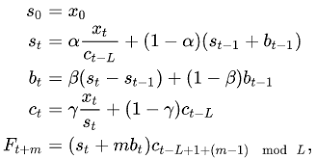 

In [ ]:
idx= df.index
idx.freq='-1D' #Set the frequency to day 

### - Frist: make Simple exp smoothing by pandas :
#### We determine prameters like alpha and span for the equation as we explained

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
span = 24
alpha= 2/(span+1)
df['EWMA_24']=df['Close'].ewm(alpha=alpha,adjust=False).mean()

### - Second:  make double exp smoothong with model/fit method
#### We determine the trend component if its multiplactive or additive manualy

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['DES_mul_24']= ExponentialSmoothing(df['Close'],trend='mul').fit().fittedvalues.shift(-1)

In [ ]:
df[['Close','DES_mul_24','EWMA_24']].plot(figsize=(12,6))

### The Close blue line and DES Orange line are above each other thats mean DES_mul discribes the data very well. What about trible exp smoothing??!

### - Third: make trible exp smoothong with model/fit method
#### We determine the trend component if its multiplactive or additive manualy and seasonal, seasonal periods

In [ ]:
df['TES_mul_12']= ExponentialSmoothing(df['Close'],trend='mul',seasonal='mul',seasonal_periods=24).fit().fittedvalues

In [ ]:
df[['Close','DES_mul_24','TES_mul_12']].plot(figsize=(12,6))

### I can't notice any change, so we will check the frist 2 years and the last 2 years then compare the 2 models in predecting in theses pperiods!

### - Frist 2 years: 

In [ ]:
df[['Close','DES_mul_24','TES_mul_12']].iloc[:24].plot(figsize=(12,6))

### - Last 2 years: 

In [ ]:
df[['Close','DES_mul_24','TES_mul_12']].iloc[-24:].plot(figsize=(12,6))

### We notice that the green line fit at the last 2 years better! We will use it at forecasting cause the TES is better algorithm for learning than DES.